In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv


# Loading Data

In [50]:

transactions    = pd.read_csv(os.path.join(dirname, 'sales_train.csv'))
items           = pd.read_csv(os.path.join(dirname, 'items.csv'))
item_categories = pd.read_csv(os.path.join(dirname, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(dirname, 'shops.csv'))
test            = pd.read_csv(os.path.join(dirname, 'test.csv'))

In [51]:
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [52]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [53]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [54]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [55]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## Checking the Null Values

In [56]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [57]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [58]:
transactions.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [59]:
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [60]:
item_categories.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

1. Merge transactions and items
2. Drop the column item_name

In [61]:
transactions = pd.merge(transactions, items, on='item_id', how='left')
transactions = transactions.drop('item_name', axis=1)
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


## Create a dataframe of Date_block_num, store and items combinations

Need to specify the sales is zero if we dont have data for item store combinations

In [62]:
from itertools import product

In [63]:
# creating the grid with the columns
groupby_cols = ['date_block_num', 'shop_id', 'item_id']


In [64]:
# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions.loc[transactions['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = transactions.loc[transactions['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
    
#turn grid into the dataframe
grid = pd.DataFrame(np.vstack(grid), columns = groupby_cols, dtype=np.int32)

In [65]:
grid.head()

,date_block_num,shop_id,item_id
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


## Mean Encodings

### We group our features by both shop_id and item_id

1.  item_cnt_day will be our target values. So, grouping the transactions and applying the aggreated functions. Also we will calculate price mean.
2. Merge with grid
3. Add item_category_id

In [66]:

mean_transactions = transactions.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
mean_transactions = pd.merge(mean_transactions, items, on='item_id',how='left')
mean_transactions.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_price,item_name,item_category_id
0,0,0,32,6.0,221.0,1+1,40
1,0,0,33,3.0,347.0,1+1 (BD),37
2,0,0,35,1.0,247.0,10 ЛЕТ СПУСТЯ,40
3,0,0,43,1.0,221.0,100 МИЛЛИОНОВ ЕВРО,40
4,0,0,51,2.0,128.5,100 лучших произведений классики (mp3-CD) (Dig...,57


###  We group individually by shop_id, by item_id and by item_category_id

Now we create additional encoding with aggregation functions on our data as follow:

[('item_price',np.mean,'avg'),

('item_cnt_day',np.sum,'sum'),

('item_cnt_day',np.mean,'avg')]

In [67]:
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        
        mean_df = transactions.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        mean_transactions = pd.merge(mean_transactions, mean_df, on=['date_block_num',type_id], how='left')

In [68]:
mean_transactions.head()

,date_block_num,shop_id,item_id,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,0,0,32,6.0,221.0,1+1,40,338.110349,299.0,1.328889,531.262049,5578.0,1.163781,244.485942,33489.0,1.145902
1,0,0,33,3.0,347.0,1+1 (BD),37,488.517241,61.0,1.051724,531.262049,5578.0,1.163781,465.036007,6094.0,1.053414
2,0,0,35,1.0,247.0,10 ЛЕТ СПУСТЯ,40,390.709091,78.0,1.418182,531.262049,5578.0,1.163781,244.485942,33489.0,1.145902
3,0,0,43,1.0,221.0,100 МИЛЛИОНОВ ЕВРО,40,234.500000,2.0,1.000000,531.262049,5578.0,1.163781,244.485942,33489.0,1.145902
4,0,0,51,2.0,128.5,100 лучших произведений классики (mp3-CD) (Dig...,57,230.461538,13.0,1.000000,531.262049,5578.0,1.163781,277.780085,1539.0,1.003914




These above lines add the following 9 features :

'item_id_avg_item_price' 'item_id_sum_item_cnt_day' 'item_id_avg_item_cnt_day' 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day' 'shop_id_avg_item_cnt_day' 'item_category_id_avg_item_price' 'item_category_id_sum_item_cnt_day' 'item_category_id_avg_item_cnt_day'


# Lag Features

we will use this lagged value (mean encoding at t-1, t-2 ..) to predict our values.

In [69]:
lag_variables  = list(mean_transactions.columns[7:])+['item_cnt_day']
lags = [1, 2, 3, 6]
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):

    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    mean_transactions = pd.merge(mean_transactions, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [70]:


mean_transactions.head()



,date_block_num,shop_id,item_id,item_cnt_day,item_price,item_name,item_category_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,...,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6
0,0,0,32,6.0,221.0,1+1,40,338.110349,299.0,1.328889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,347.0,1+1 (BD),37,488.517241,61.0,1.051724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,247.0,10 ЛЕТ СПУСТЯ,40,390.709091,78.0,1.418182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,221.0,100 МИЛЛИОНОВ ЕВРО,40,234.500000,2.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,128.5,100 лучших произведений классики (mp3-CD) (Dig...,57,230.461538,13.0,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fill NA with 0

In [71]:


mean_transactions = mean_transactions[mean_transactions['date_block_num']>12]



In [72]:
for feat in mean_transactions.columns:
    if 'item_cnt' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(0)
    elif 'item_price' in feat:
        mean_transactions[feat]=mean_transactions[feat].fillna(mean_transactions[feat].median())


### Lets drop the columns that are not lagged.

1. Drop item_name and item_price

In [73]:
# dropping all target variables but not "item_cnt_day" cause is target
cols_to_drop = lag_variables[:-1] + ['item_price', 'item_name'] 

training = mean_transactions.drop(cols_to_drop,axis=1)



# Train our model

In [74]:


import xgboost as xgb



In [75]:


xgbtrain = xgb.DMatrix(training.iloc[:, training.columns != 'item_cnt_day'].values, training.iloc[:, training.columns == 'item_cnt_day'].values)



In [76]:
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'} # random parameters
bst = xgb.train(param, xgbtrain)

[04:09:37] WARNING: ../src/learner.cc:516: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




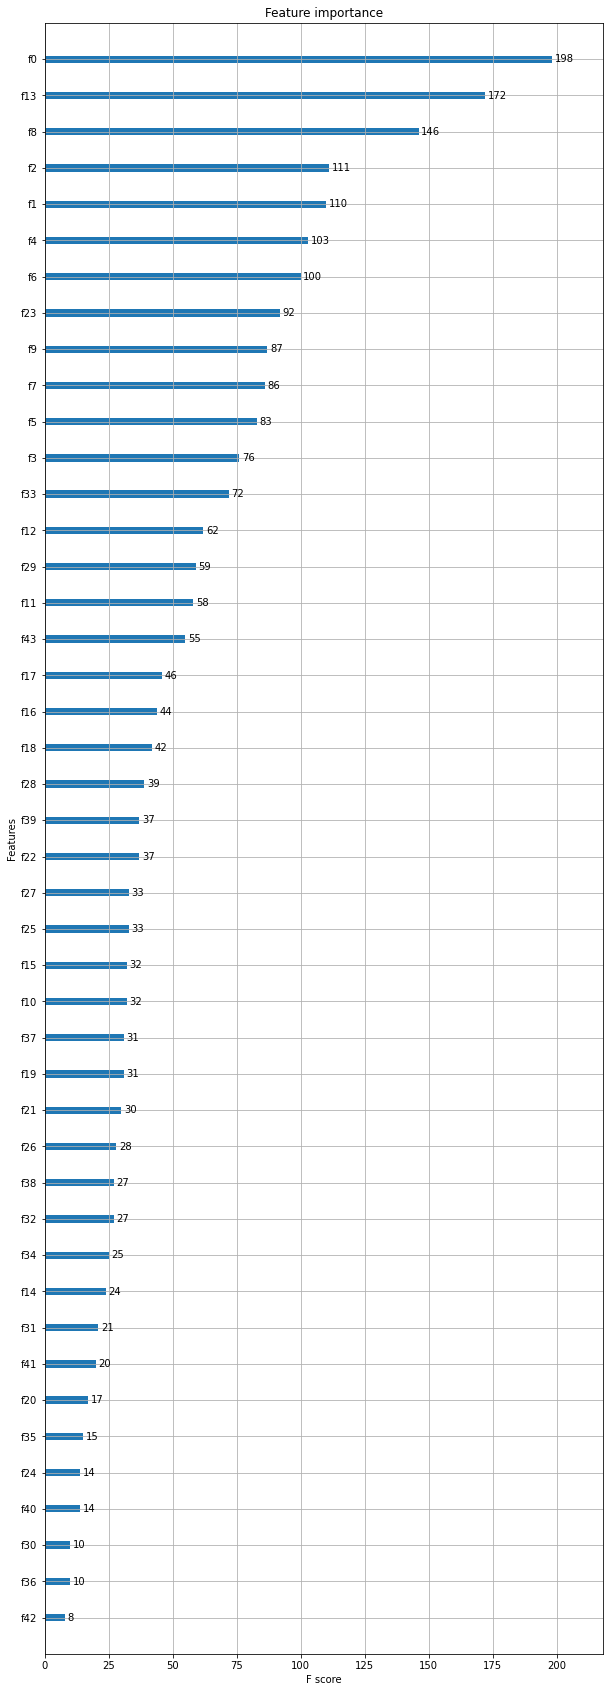

In [77]:
x=xgb.plot_importance(bst)
x.figure.set_size_inches(10, 30) 



The most important features (2 0 5 8 4 1 3 9 33) are:


In [79]:
cols = list(training.columns)
# eliminate target feature col name
del cols[cols.index('item_cnt_day')] 

In [80]:
[cols[x] for x in [2, 0, 5, 8, 4, 1, 3, 9, 33]]


['item_id',
 'date_block_num',
 'item_id_sum_item_cnt_day_lag_1',
 'shop_id_sum_item_cnt_day_lag_1',
 'item_id_avg_item_price_lag_1',
 'shop_id',
 'item_category_id',
 'shop_id_avg_item_cnt_day_lag_1',
 'item_cnt_day_lag_3']

# Preparing predictions


In [81]:
training.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_day',
       'item_category_id', 'item_id_avg_item_price_lag_1',
       'item_id_sum_item_cnt_day_lag_1', 'item_id_avg_item_cnt_day_lag_1',
       'shop_id_avg_item_price_lag_1', 'shop_id_sum_item_cnt_day_lag_1',
       'shop_id_avg_item_cnt_day_lag_1',
       'item_category_id_avg_item_price_lag_1',
       'item_category_id_sum_item_cnt_day_lag_1',
       'item_category_id_avg_item_cnt_day_lag_1', 'item_cnt_day_lag_1',
       'item_id_avg_item_price_lag_2', 'item_id_sum_item_cnt_day_lag_2',
       'item_id_avg_item_cnt_day_lag_2', 'shop_id_avg_item_price_lag_2',
       'shop_id_sum_item_cnt_day_lag_2', 'shop_id_avg_item_cnt_day_lag_2',
       'item_category_id_avg_item_price_lag_2',
       'item_category_id_sum_item_cnt_day_lag_2',
       'item_category_id_avg_item_cnt_day_lag_2', 'item_cnt_day_lag_2',
       'item_id_avg_item_price_lag_3', 'item_id_sum_item_cnt_day_lag_3',
       'item_id_avg_item_cnt_day_lag_3', 'shop_id_avg_i

We need these columns above without 'item_cnt_day', and we have only the column below



So we need to manipulate the training set similarly to how we did in the first part of the notebook.

    add date_block_num = 34
    add category_id
    add lagging



In [82]:
test = pd.read_csv(os.path.join(dirname, 'test.csv'))
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [83]:
test['date_block_num'] = 34

test = pd.merge(test, items, on='item_id', how='left')

In [84]:
from tqdm import tqdm_notebook
for lag in tqdm_notebook(lags):

    sales_new_df = mean_transactions.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    test = pd.merge(test, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [85]:
_test = set(test.drop(['ID', 'item_name'], axis=1).columns)
_training = set(training.drop('item_cnt_day',axis=1).columns)
for i in _test:
    assert i in _training
for i in _training:
    assert i in _test

In [86]:


assert _training == _test



In [87]:
test = test.drop(['ID', 'item_name'], axis=1)


In [88]:
xgbpredict = xgb.DMatrix(test.values)

In [89]:
pred = bst.predict(xgbpredict)


In [90]:
pd.Series(pred).describe()

count    214200.000000
mean         50.446152
std          22.840885
min           0.898057
25%          40.649006
50%          52.219059
75%          58.930016
max         320.178589
dtype: float64

In [91]:
pred = pred.clip(0, 20)

In [92]:
pred.sum()

3853489.2

In [93]:
pd.Series(pred).describe()


count    214200.000000
mean         17.989288
std           5.684656
min           0.898057
25%          20.000000
50%          20.000000
75%          20.000000
max          20.000000
dtype: float64

In [94]:
sub_df = pd.DataFrame({'ID':test.index,'item_cnt_month': pred })

In [95]:
sub_df.to_csv('submission.csv',index=False)

In [ ]:
sub_df.head()